In [9]:
!pip install pandas numpy matplotlib seaborn scikit-learn nltk gradio
!pip install pandas numpy matplotlib seaborn scikit-learn nltk gradio openpyxl xlrd

In [1]:
# 🧾 Section 1: Imports
import pandas as pd
import numpy as np
import re
import string
import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

import gradio as gr


[nltk_data] Downloading package punkt to /home/hi-born/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/hi-
[nltk_data]     born/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hi-born/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /home/hi-
[nltk_data]     born/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/home/hi-born/miniconda3/envs/cstp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 📁 Section 2: Load and Explore Dataset
df = pd.read_excel("ai_dev_assignment_tickets_complex_1000.xls")

# Display basic info
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ticket_id      1000 non-null   int64 
 1   ticket_text    945 non-null    object
 2   issue_type     924 non-null    object
 3   urgency_level  948 non-null    object
 4   product        1000 non-null   object
dtypes: int64(1), object(4)
memory usage: 39.2+ KB


,ticket_id,ticket_text,issue_type,urgency_level,product
0,1,Payment issue for my SmartWatch V2. I was unde...,Billing Problem,Medium,SmartWatch V2
1,2,Can you tell me more about the UltraClean Vacu...,General Inquiry,NaN,UltraClean Vacuum
2,3,I ordered SoundWave 300 but got EcoBreeze AC i...,Wrong Item,Medium,SoundWave 300
3,4,Facing installation issue with PhotoSnap Cam. ...,Installation Issue,Low,PhotoSnap Cam
4,5,Order #30903 for Vision LED TV is 13 days late...,Late Delivery,NaN,Vision LED TV


In [9]:
import nltk
nltk.download('punkt')  # This is the correct resource
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
# import nltk
# nltk.download('punkt')
nltk.download('punkt_tab')  # this may not exist, but resolves some edge cases
# nltk.download('stopwords')
# nltk.download('wordnet')


[nltk_data] Downloading package punkt to /home/hi-born/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/hi-
[nltk_data]     born/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hi-born/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /home/hi-
[nltk_data]     born/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/hi-
[nltk_data]     born/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [10]:
# 🧹 Section 3: Data Cleaning and Preprocessing

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = clean_text(text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [12]:
df['clean_text'] = df['ticket_text'].apply(preprocess_text)

# Drop NA values
df.dropna(inplace=True)

In [13]:
# 📐 Section 4: Feature Engineering

# Ticket length
df['ticket_length'] = df['ticket_text'].apply(lambda x: len(str(x).split()))

# Sentiment Score
sia = SentimentIntensityAnalyzer()
df['sentiment'] = df['ticket_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# TF-IDF Features
tfidf = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf.fit_transform(df['clean_text'])


In [16]:
# 🔍 Section 5: Classification Models

# Combine features
X = pd.concat(
    [pd.DataFrame(X_tfidf.toarray()), df[['ticket_length', 'sentiment']].reset_index(drop=True)],
    axis=1
)

# Ensure all column names are strings BEFORE train/test split
X.columns = X.columns.astype(str)

# Labels
y_issue = df['issue_type']
y_urgency = df['urgency_level']

# Train/Test Split
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X, y_issue, test_size=0.2, random_state=42)
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X, y_urgency, test_size=0.2, random_state=42)

# Model 1: Issue Type Classifier
clf_issue = RandomForestClassifier()
clf_issue.fit(X_train_i, y_train_i)
pred_i = clf_issue.predict(X_test_i)

# Model 2: Urgency Level Classifier
clf_urgency = LogisticRegression(max_iter=1000)
clf_urgency.fit(X_train_u, y_train_u)
pred_u = clf_urgency.predict(X_test_u)


In [17]:
# 🏷️ Section 6: Entity Extraction

PRODUCT_LIST = df['product'].dropna().unique().tolist()
COMPLAINT_KEYWORDS = ['broken', 'late', 'error', 'damaged', 'not working', 'crash']

def extract_entities(text):
    entities = {}
    text_lower = text.lower()
    
    # Product name
    found_product = [p for p in PRODUCT_LIST if p.lower() in text_lower]
    entities['product'] = found_product if found_product else None
    
    # Date extraction (simple regex)
    dates = re.findall(r'\b(?:\d{1,2}[-/th|st|rd|nd\s]*)?(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)[a-z]*[\s/-]*\d{2,4}\b|\b\d{1,2}/\d{1,2}/\d{2,4}\b', text_lower)
    entities['dates'] = dates if dates else None

    # Complaint keywords
    complaints = [word for word in COMPLAINT_KEYWORDS if word in text_lower]
    entities['complaints'] = complaints if complaints else None

    return entities


In [18]:
# 🔄 Section 7: Integration Function

def analyze_ticket(text):
    text_clean = preprocess_text(text)
    tfidf_vec = tfidf.transform([text_clean])
    length = len(text.split())
    sentiment = sia.polarity_scores(text)['compound']
    
    features = np.hstack([tfidf_vec.toarray(), [[length, sentiment]]])
    
    issue_pred = clf_issue.predict(features)[0]
    urgency_pred = clf_urgency.predict(features)[0]
    entities = extract_entities(text)
    
    return {
        "predicted_issue_type": issue_pred,
        "predicted_urgency_level": urgency_pred,
        "extracted_entities": entities
    }

# Test
analyze_ticket("My phone stopped working after the update on 15th May. It's a Pixel 5.")


/home/hi-born/miniconda3/envs/cstp/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/hi-born/miniconda3/envs/cstp/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


{'predicted_issue_type': 'Product Defect',
 'predicted_urgency_level': 'High',
 'extracted_entities': {'product': None, 'dates': None, 'complaints': None}}

In [19]:
# 🖼️ Section 8: Gradio App (Optional)

def gradio_interface(text):
    result = analyze_ticket(text)
    return f"Issue Type: {result['predicted_issue_type']}\nUrgency: {result['predicted_urgency_level']}\nEntities: {json.dumps(result['extracted_entities'], indent=2)}"

gr.Interface(fn=gradio_interface, 
             inputs="text", 
             outputs="text", 
             title="Customer Support Ticket Analyzer").launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


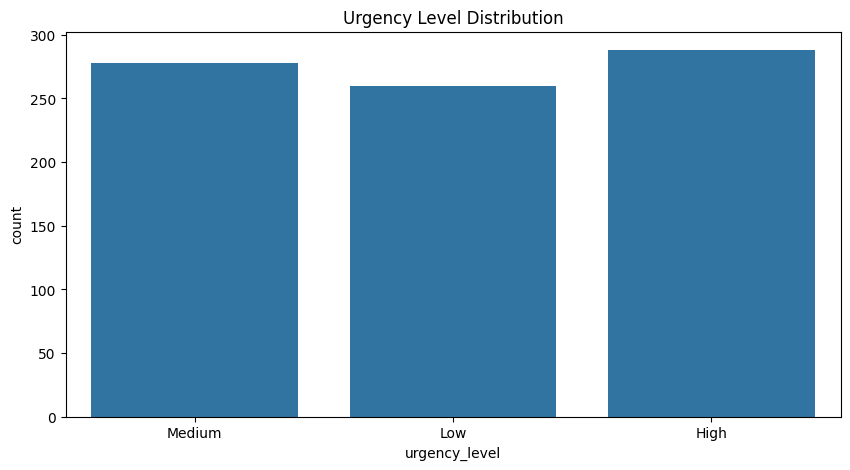

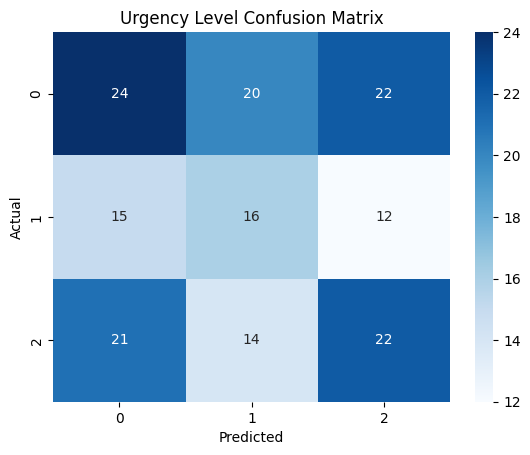

/home/hi-born/miniconda3/envs/cstp/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/hi-born/miniconda3/envs/cstp/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Created dataset file at: .gradio/flagged/dataset1.csv


In [20]:
# 📊 Section 9: Bonus Visualizations (Optional)

# Distribution of tickets
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='urgency_level')
plt.title("Urgency Level Distribution")
plt.show()

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test_u, pred_u), annot=True, fmt='d', cmap='Blues')
plt.title("Urgency Level Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
